## This notebook is a compilation of what is needed to reproduce the results from the paper in a basic way.

The main point of this is to have a coherent way to walk someone through the calculations and have them understand what is needed and what is obtained.

In [1]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import numpy.testing as npt

For this simulation we need the hamiltonian and the Lindblad master equation:

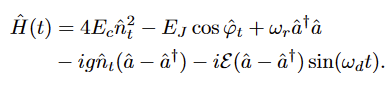

$\varepsilon$ is the drive amplitude and $\omega_d$ is the drive frequency on the resonator. $\hbar$ is assumed to be 1. $E_c$ is the transmon charging energy, $E_J$ is the Josephson energy, and n and phi are the charge and phase operators.
$E_J/E_C=50$, $E_c = 280MHz$, $\omega_t = 7.5GHz$ amd $g/2\pi=250 MHz$. The drive $\varepsilon/2\pi\space\epsilon [0,450] MHz$. Resonator loss rate of $\kappa/2\pi=20 MHz$. 

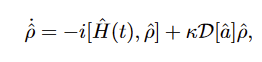

The dissipator:
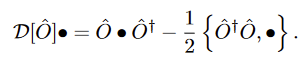
Here O and the dot are the lowering operator and density matrix respectively

The system starts in a dressed ground or excited state.


In [2]:
'''
First we gotta set up the constants for our simulation
'''
E_C = .280 #GHz
E_J = 50*E_C
omega_r = 7.500 #GHz
#omega_r = 2*np.pi*7.500 #GHz
#g = 2*np.pi*.250 #GHz
g = .250 #GHz
kappa = 2*np.pi*0.020 #GHz
#kappa = 0.020 #GHz
omega_d = omega_r
#omega_d = 2*np.pi*omega_r

The tricky part about simulating this hamiltonian is the fact that we are using two systems so we have to do the hamiltonian in the correct matrix basis and end up adding a lot of dimensionality to it. First I create the hamiltonian for the Transmon only:

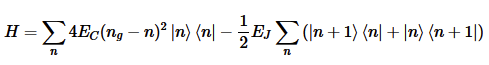

and then I must make the one for the readout. Afterwards I must tensor product and add the interaction terms

In [3]:
'''
Must make the hamiltonian of the system including the interaction terms
'''
def hamiltonian(t, Ec, Ej, N1, N2, omega_r, drive_amp, drive_f, g):
    """
    Return the transmon hamiltonian as a Qobj instance.
    N1 is the qubit order that we are using.
    Ec is the charging energy.
    Ej is the Josephson energy.
    N2 is the readout order that we are using.
    omega_r is the resonator frequency.
    drive_amp is the drive amplitude.
    drive_f is the drive frequency.
    g is the coupling.
    t is time.
    """
    assert N1 != 1
    assert N2 != 1
    
    cos = np.diag(np.ones(N1-1), 1) + np.diag(np.ones(N1-1), -1)
    nt = qt.num(N1)**2 
    transmon = 4 * Ec * ( nt )**2 - 0.5 * Ej * (cos)
                 
    resonator = omega_r*qt.create(N2)*qt.destroy(N2) - 1.j*drive_amp*(qt.destroy(N2)-qt.create(N2))*np.sin(drive_f*t)
    
    interaction = -1.j*g*qt.tensor(qt.num(N1), (qt.destroy(N2)-qt.create(N2)))
    
    Hamilton = qt.tensor(transmon, qt.qeye(N2)) + interaction + qt.tensor(qt.qeye(N1), resonator)
    return Hamilton

### Decoherence & Readout

Now gotta setup the decoherence and readout operators

In [4]:
def resonator_loss(N1,N2):
    return qt.tensor(qt.qeye(N1), qt.destroy(N2))
def number_qubit(N1,N2):
    return qt.tensor(qt.num(N1), qt.qeye(N2))
def number_resonator(N1,N2):
    return qt.tensor(qt.qeye(N1), qt.num(N2))

### Initial states

Set up the initial states of the qubit and resonator to explore the desired case. 
The system is initialized in the dressed ground state and in the dressed excited state. 

In [5]:
def ground_state(N1, N2):
    return qt.tensor(qt.basis(N1),qt.basis(N2))
def excited_state(N1, N2):
    return qt.tensor(qt.basis(N1,2),qt.basis(N2))

### Qubit dynamics

Setting up the variables of our system.

In [6]:
times = np.linspace(0, 1/kappa, 51) #0 to kappta*t=1
drives = 2*np.pi*np.linspace(0, 0.450, 11) #GHz

### Setting up the actual simulation
Here I create the actual initial states, relevant operators, ...

In [7]:
drive1 = 2*np.pi*0.28
N1 = 4 # 32 is what the paper uses
N2 = 50 # 1024 is what the paper uses
nq = number_qubit(N1, N2)
nr = number_resonator(N1, N2)
init_g = ground_state(N1,N2)
init_e = excited_state(N1,N2)
decay = resonator_loss(N1,N2)

args = {}
opts = qt.Options(store_states=True)
#A = nq*init_g
#np.sum(A[:])
def H(t, idk):
    return hamiltonian(t,E_C, E_J, N1, N2, omega_r, drive1, omega_d, g)

Solving with the Lindblad Master equation. No guarantee that the below function will converge in a sensible amount of time!

Using the 32 and 1024 dimensions that the paper uses is a guarantee for using a ridiculous amount of memory.

In [8]:
result_init_g = qt.mesolve(H, init_g, times, [kappa*decay],[nq,nr], args = args, options = opts, progress_bar = BaseProgressBar)
result_init_g

Result object with mesolve data.
--------------------------------
expect = True
num_expect = 2, num_collapse = 1

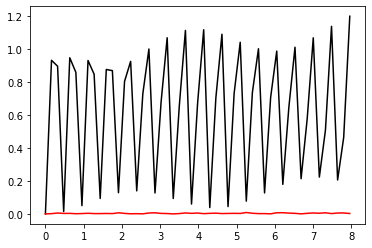

In [9]:
plt.plot(times, result_init_g.expect[0], color = 'black')
plt.plot(times, result_init_g.expect[1], color = 'r')

In [14]:
result_init_g.states

[]

In [10]:
result_init_e = qt.mesolve(H, init_e, times, [kappa*decay],[nq,nr], args = args, options = opts, progress_bar = BaseProgressBar)
result_init_e

KeyboardInterrupt: 

In [ ]:
plt.plot(times, result_init_e.expect[0], color = 'black')
plt.plot(times, result_init_e.expect[1], color = 'r')

In [ ]:
np.sum(result_init_g.expect[0])/len(result_init_g.expect[0])

In [ ]:
np.sum(result_init_e.expect[0])/len(result_init_e.expect[0])